In [1]:
import numpy as np
import os
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
#sort_by_target(mnist) # fetch_openml() returns an unsorted dataset


How many examples are in the dataset? What is the shape of the data? What is the shape of y? How many distinct values has y?

In [4]:
mnist.data.shape

(70000, 784)

In [5]:
X, y = mnist["data"], mnist["target"]
X.shape   # 28x28=784

(70000, 784)

In [6]:
y.shape

(70000,)

In [13]:
np.unique(y, return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8),
 array([6903, 7877, 6990, 7141, 6824, 6313, 6876, 7293, 6825, 6958]))

Take one instance and visualize it

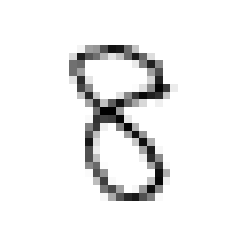

In [39]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary,
           interpolation="nearest")
plt.axis("off")

plt.show()

What is the class of the image?

In [9]:
y[36000]

9

- Split the dataset in train and test. 
- Shuffle the dataset

In [11]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]


shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Binary classifier

y has 10 different values. We can transform the multiclass classification problem to binary classification (one vs all): is it a 5 or not?

In [14]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)
y_train_5

array([ True, False, False, ..., False, False, False])

Start with a simple classifier.

In [15]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=-inf, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [16]:
#predict the visualized digit
sgd_clf.predict([some_digit])

array([False])

In [17]:
# use cross validation 
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.94955, 0.94245, 0.96765])

It looks like we found a very good classifier, with accuracy around 0.94. 

Let's see what happens if we use a dumb classifier wicth classifies every single image in not-5 class.

In [18]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [19]:
#use cross validation with the dumb classifier
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91175, 0.9085 , 0.9087 ])

We have an <strong>imbalanced</strong> dataset

In [20]:
np.unique(y_train_5, return_counts = True)

(array([False,  True]), array([54579,  5421]))

### Confusion matrix 
Before drawing any conclusion about the classifier, look at the confusion matrix.

In [26]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
#it depends on the actual class and the predicted class
cf = confusion_matrix(y_train_5, y_train_pred)
cf

array([[52813,  1766],
       [ 1041,  4380]])

In [22]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

Compute precision, recall

In [23]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.7126586397657013

In [24]:
recall_score(y_train_5, y_train_pred)

0.8079690094078583

In [30]:
#check manually the values
TP, FN = cf[1][1], cf[1][0]
FP, TN = cf[0][1], cf[0][0]

In [31]:
prec = TP/(TP+FP) # for class y=5
prec

0.7126586397657013

In [33]:
recall = TP/(TP+FN)
recall

0.8079690094078583

So our classifier does not actually predict so well the 5.

### Tradeoff between precision and recall

Choose and image which is a 5 in order to understand the role of the tradeoff

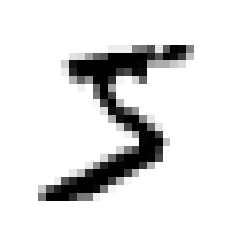

In [47]:
some_digit = X[[i for i in range(20) if y_train[i]==5]][0]

some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary,
           interpolation="nearest")
plt.axis("off")

plt.show()

What is actually the result of the classifier?

In [48]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([209080.13703584])

Instead of using the predict function, use the score to write your prediction based on this score

In [49]:

threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [50]:
threshold = 300000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

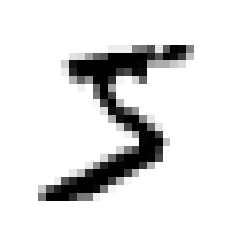

Which threshold to choose?

Use again cross validation, but not with predict scores, but with decision scores.

In [54]:
#Get the scores of all instances in teh training set
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [53]:
y_scores.shape

(60000,)

In [55]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

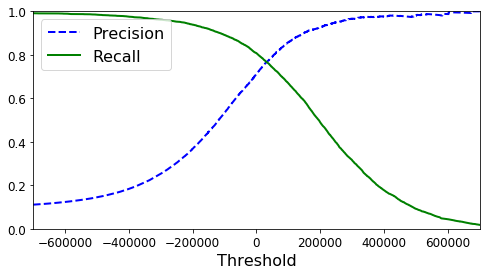

In [57]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
plt.show()

Based on the Precision and recall versus the decision threshold, the values that give the best tradeoff can be chosen.

<strong>Which precision do you want? At which recall?</strong>

Let's analyse precision recall for different thresholds

In [58]:
y_train_pred_90 = (y_scores > 70000)
precision_score(y_train_5, y_train_pred_90)

0.821322594319627

In [59]:
recall_score(y_train_5, y_train_pred_90)

0.7148127651724774

Instead, precision versus recall curve can be used.

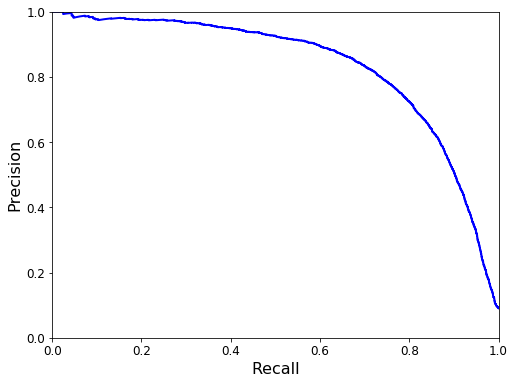

In [61]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)

plt.show()

## ROC curve

For different values of threshold, compute TPR(recall or sensitivity) and FPR(1-specificty)

In [64]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

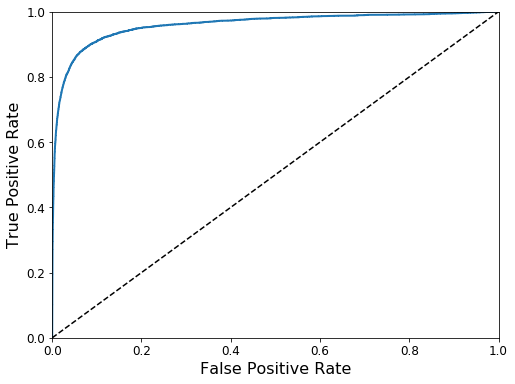

In [65]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)

plt.show()

In [66]:
#COmpute area under the curve ROC AUC
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9595985414797851

### Use ROC AUC to compare more algorithms

In [70]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")
y_probas_forest[0] # it returns a probability for each class

array([0.3, 0.7])

In [71]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

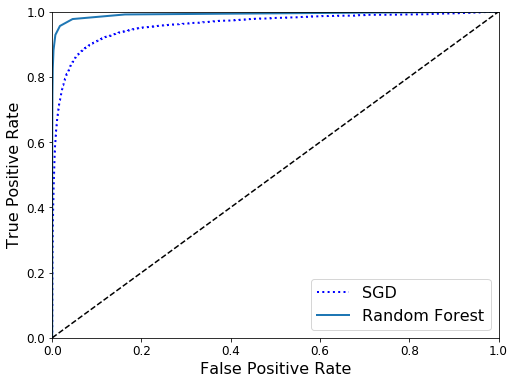

In [72]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [73]:
roc_auc_score(y_train_5, y_scores_forest)

0.9920171478172479

It looks like Random Forest is better, since AUC is cloaser to 1.

In [75]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9847917125854089

In [76]:
recall_score(y_train_5, y_train_pred_forest)

0.8242021767201624